/opt/conda/lib/python3.13/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


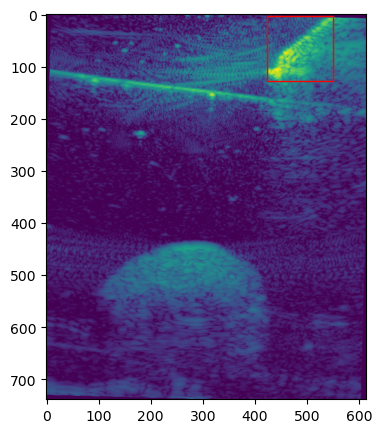

26

Epoch [1/5]
0.33634860011247486
0.31590434264492345

Epoch [2/5]
0.19130223817550218
0.16103800446600527

Epoch [3/5]
0.1519432830122801
0.1461444340042166

Epoch [4/5]
0.14276940662127274
0.1385518393001041

Epoch [5/5]
0.13656771469574708
0.14136637102913213


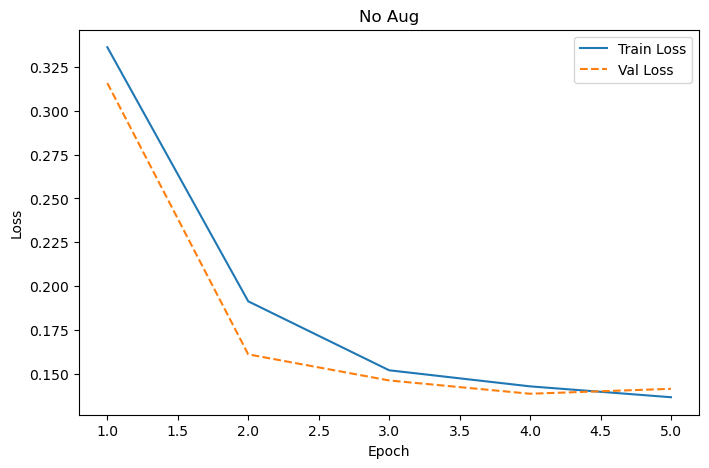

tensor([[443.6256,   0.0000, 613.0000, 139.5882]], device='cuda:0')
2
boxes1[0]--> [443.62564   0.      613.      139.58823]
tensor([[  0.0000, 131.3776, 483.3125, 624.0445]], device='cuda:0')
2
boxes1[0]--> [  0.      131.37758 483.3125  624.0445 ]
tensor([[439.5201,  49.2665, 564.0553, 169.6962]], device='cuda:0')
2
boxes1[0]--> [439.52008   49.266544 564.0553   169.6962  ]
tensor([[ 19.3846, 130.0093, 505.2086, 628.1500]], device='cuda:0')
2
boxes1[0]--> [ 19.384592 130.00931  505.20856  628.15    ]


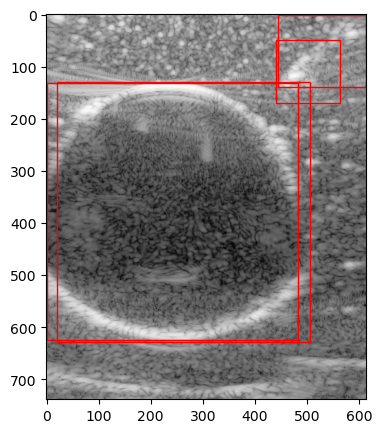

{'map': tensor(0.1716), 'map_50': tensor(0.6675), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.1716), 'mar_1': tensor(0.2250), 'mar_10': tensor(0.2250), 'mar_100': tensor(0.2250), 'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.2250), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2], dtype=torch.int32)}


In [1]:
## -*- coding: utf-8 -*-

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.transforms import transforms

import time
import datetime
from collections import defaultdict, deque


import albumentations as A 
from albumentations.pytorch import ToTensorV2
from usaugment.albumentations import (DepthAttenuation, 
                                     GaussianShadow, 
                                     HazeArtifact, 
                                     SpeckleReduction,) 

# ----------------------------- Dataset -----------------------------
class USDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, use_albumentations=True):
        self.data = pd.read_csv(csv_file)
        bbox_cols = self.data.columns[2:6]
        self.data[bbox_cols] = self.data[bbox_cols].apply(pd.to_numeric, errors="raise")
        self.img_dir = img_dir
        self.transform = transform
        self.use_albumentations = use_albumentations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255.0
        
        bbox = self.data.iloc[idx, 2:6].to_numpy(dtype=np.float32)
        label = int(self.data.iloc[idx, 1])

        boxes=[bbox]
        #print(boxes)
        labels = [label]
        #print(label)

        if self.use_albumentations and  self.transform is not None:
            dummy_mask = np.ones(image.shape[:2], dtype=np.uint8)
            transformed = self.transform(
                image=image,
                scan_mask=dummy_mask,
                bboxes=[bbox],
                labels=[label]
            )
            image=transformed["image"]
            boxes=torch.tensor(transformed["bboxes"], dtype=torch.float32)
            labels=torch.tensor(transformed["labels"], dtype=torch.int64)
            
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            boxes = torch.tensor([bbox], dtype=torch.float32)
            labels = torch.tensor([label], dtype=torch.int64)

        return image, {"boxes": boxes, "labels": labels}


def collate_fn(batch):
    return tuple(zip(*batch))


class SmoothedValue:
    def __init__(self, window_size=20, fmt="{median:.4f} ({global_avg:.4f})"):
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count if self.count > 0 else 0

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg
        )


class MetricLogger:
    def __init__(self, delimiter="  "):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            self.meters[k].update(v)

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        start_time = time.time()
        header = header or ""

        for obj in iterable:
            yield obj
            if i % print_freq == 0:
                elapsed = time.time() - start_time
                eta_seconds = elapsed / max(1, i + 1) * (len(iterable) - i - 1)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))

                log = [header, f"[{i}/{len(iterable)}]", f"eta: {eta_string}"]
                log += [f"{name}: {meter}" for name, meter in self.meters.items()]
                print(self.delimiter.join(log))
            i += 1






# ----------------------------- Training -----------------------------
def train_frcnn(model, train_loader, val_loader, optimizer, device,epochs=5):
    
    train_losses, val_losses,  = [], []

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch + 1}/{epochs}]")
        metric_logger = MetricLogger()
        
        model.train()
        train_loss = 0.0

        for images, targets in train_loader:
            images = [img.to(device).float() for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            metric_logger.update(
                loss = loss.item(),
                **{k:v.item() for k, v in loss_dict.items()}
            )
    
        train_loss = metric_logger.meters["loss"].global_avg
        print(train_loss)
        train_losses.append(train_loss)
    #------------------------------------------------------------------------------------
        model.eval()
        metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
        metric.to(device)
       
        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device).float() for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                outputs = model(images)

                for target, output in zip(targets, outputs):
                    metric.update([output], [target])
                
                metric_logger.update(
                    loss = loss.item(),
                    **{k:v.item() for k, v in loss_dict.items()}
        )

        val_loss = metric_logger.meters["loss"].global_avg
        print(val_loss)
        val_losses.append(val_loss)


    loss_df = pd.DataFrame({"epoch": range(1,len(train_losses)+1),
                            "train loss": train_losses,
                            "val loss": val_losses,})
    
    return model, loss_df







# ----------------------------- Evaluation -----------------------------
def evaluate_frcnn(model, dataloader, num_classes=3):
    
    model.eval()
    metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
    metric.to(device)
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device).float() for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            image1 = images[0].cpu().numpy()
            #print(image1.shape)
            image2 = np.transpose(image1,(1,2,0))
            #print(image2.shape)
            fig, ax = plt.subplots(1, figsize=(5,5))
            ax.imshow(image2)
            
            for target, output in zip(targets, outputs):
                    metric.update([output], [target])

                    print(target["boxes"])
                    print(len(target))

                    boxes1 = target["boxes"].cpu().numpy()
                    print("boxes1[0]-->",boxes1[0])
                    for box in boxes1:
                                    x_min, y_min, x_max, y_max = box 
                                    width = x_max - x_min
                                    height = y_max - y_min
                    rect = patches.Rectangle((x_min,y_min), width, height, linewidth=1,edgecolor="r", facecolor='none')
                    ax.add_patch(rect)
            plt.show()
            break
                
        results = metric.compute()
        print(results)
        mAP = results["map"]
        
        return mAP



        
        
        
# ----------------------------- Run -----------------------------
if __name__ == "__main__":
    train_csv = "labels/frcnn_labels_train.csv"
    train_dir = "images/train"
    val_csv = "labels/frcnn_labels_val.csv"
    val_dir = "images/val"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    train_transform = A.Compose([ A.HorizontalFlip(p=1.0),
                                  A.Rotate(limit=10,p=1.0),
                                  DepthAttenuation(p=1.0, attenuation_rate=1.0),
                                  
                                  #A.Normalize(
                                   #   mean =(0.485, 0.456, 0.406),
                                    #  std=(0.229, 0.224, 0.225),
                                  #),
                                            ToTensorV2(),
                                
                                ], 
                               bbox_params=A.BboxParams(
                                   format="pascal_voc",
                                   label_fields=["labels"]),
                                additional_targets={"scan_mask":"mask"})
       

    val_transform = A.Compose([ #A.Normalize(
                                        #mean=(0.485, 0.456, 0.406),
                                        #std=(0.229, 0.224, 0.225),
                                    #),
                                                ToTensorV2(),
                                              ],
                                              bbox_params=A.BboxParams(
                                                  format="pascal_voc",
                                                  label_fields=["labels"],
                                              ),
                                             )

    
    train_dataset = USDataset(train_csv, train_dir, transform=train_transform)
    val_dataset = USDataset(val_csv, val_dir, transform=val_transform)
    
    for images, targets in train_dataset:
        
        image1 = images[0].cpu().numpy()
        #print(image1.shape)
        #image2 = np.transpose(image1,(1,2,0))
        #print(image2.shape)
        
        fig, ax = plt.subplots(1, figsize=(5,5))
        ax.imshow(image1)
            
        #print(target["boxes"])
        #print(len(target))
        #for target in targets:
        boxes1 = targets['boxes'].cpu().numpy()
        boxes1 = boxes1[0]
        #print("boxes_raw[0]-->",boxes1)
        x_min, y_min, x_max, y_max = boxes1
        #print(x_min)
        width = x_max - x_min
        height = y_max - y_min
                                    
        rect = patches.Rectangle((x_min,y_min), width, height, linewidth=1,edgecolor="r", facecolor='none')
        ax.add_patch(rect)
        plt.show()
        break

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
    print(len(train_loader))
    print(train_loader)

    num_classes = 3
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.000025)

    model, loss_df = train_frcnn(model, train_loader, val_loader, optimizer, device)

    loss_df.to_csv("results/frcnn_losses.csv", index=False)
    plt.figure (figsize=(8,5))   
    plt.plot(loss_df["epoch"], loss_df["train loss"], label= "Train Loss", linestyle="-")
    plt.plot(loss_df["epoch"], loss_df["val loss"], label= "Val Loss", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("No Aug")
    plt.legend()
    plt.savefig ("loss curve.png")
    plt.show()
   

    mAP = evaluate_frcnn(model, val_loader)
    
    metrics = pd.DataFrame([{
        "mAP_(0.50-0.95)": mAP
        
    }])
    
    metrics.to_csv("results/frcnn_metrics.csv", index=False)
